# EEG Preprocessing Notebook

In this notebook I'll preprocess the data and create new files for resample, reref, etc.

Clear all and define required variables

In [1]:
% only run this cell if variables are messed up
clearvars;
ft_defaults;

### Setup

The variables required to run this analysis. Always run this cell first, as it also generates the list of files for you!

In [3]:
electrodes = 'all';
stimfreq = 5.0;

triggers = [16, 32, 64, 100];

trialdur = 10.0;
discardstart = 0.0;

% provide directory of the data files & naming pattern here
if exist('C:\EEG Data\cancan\', 'dir')
    filedir = 'C:\EEG Data\cancan\';
elseif exist('/data/group/FANS/cancan/eeg/', 'dir')
    filedir = '/data/group/FANS/cancan/eeg/';
end

files = dir([filedir, '*sat*.eeg']);

for isubject = 1:numel(files)
    files(isubject).id = regexprep(files(isubject).name, '(_)', '');
    [idstart, idend] = regexp(files(isubject).id, '(\d+)[ABCabc]');
    files(isubject).id = files(isubject).id(idstart:idend);
end

### Data Analysis Step 1: Defining the trials

In this section, the trials are defined.

In [7]:
for isubject = 1:numel(files)
    clear prep_data cfg*
    
    
    % Trial Basics
    cfg_deftrials.dataset = fullfile(filedir, files(isubject).name);
    cfg_deftrials.trialdef.eventtype = 'Toggle';
    cfg_deftrials.trialfun = 'ft_trialfun_general';
    % Trial Timing
    cfg_deftrials.trialdef.prestim = -discardstart;
    cfg_deftrials.trialdef.poststim = trialdur;
    
    trl{isubject} = [];  % initialise to append
    for trigger = triggers
        cfg_deftrials.trialdef.eventvalue = sprintf('T% 3u', trigger);
        disp(sprintf('T% 3u', trigger))
        try
            tmp = ft_definetrial(cfg_deftrials);
        catch
            % If triggers are not as expected, skip subject
            continue
        end
        % Manually add the trigger code
        tmp.trl(:, 4) = trigger;
        trl{isubject} = vertcat(trl{isubject}, tmp.trl);
    end

end

T 16
evaluating trialfunction 'ft_trialfun_general'
reading the events from 'C:\EEG Data\cancan\cancan_016b-saturation.vhdr'
found 24 events
created 4 trials
the call to "ft_definetrial" took 0 seconds
T 32
evaluating trialfunction 'ft_trialfun_general'
reading the events from 'C:\EEG Data\cancan\cancan_016b-saturation.vhdr'
found 24 events
created 4 trials
the call to "ft_definetrial" took 0 seconds
T 64
evaluating trialfunction 'ft_trialfun_general'
reading the events from 'C:\EEG Data\cancan\cancan_016b-saturation.vhdr'
found 24 events
created 4 trials
the call to "ft_definetrial" took 0 seconds
T100
evaluating trialfunction 'ft_trialfun_general'
reading the events from 'C:\EEG Data\cancan\cancan_016b-saturation.vhdr'
found 24 events
created 4 trials
the call to "ft_definetrial" took 0 seconds
T 16
evaluating trialfunction 'ft_trialfun_general'
reading the events from 'C:\EEG Data\cancan\cancan_019c-saturation.vhdr'
found 22 events
created 4 trials
the call to "ft_definetrial" took 

### Data Analysis Step 2: Resampling the data

In this section the data gets "preprocessed" only to the extent that it's snipped to the right length and resampled. In addition, a 50Hz filter and an extreme lowpass filter is applied.

In [11]:
for isubject = 1:numel(files)
    % Skip participant if no trials defined
    if isempty(trl{isubject})
        continue
    end
    
    % Define the config
    cfg = [];
    cfg.dataset = fullfile(filedir, files(isubject).name);
    cfg.trl = trl{isubject}; % previously defined
    cfg.channel = electrodes; % defined above
    cfg.demean = 'yes';  % Subtract mean within each trial
    cfg.detrend = 'yes';  % equivalent to hi-pass filter
    cfg.reref = 'no'; % done in step 3
    cfg.lpfilter = 'yes'; % low pass filter
    cfg.lpfreq = 25;
    
    prep_data = ft_preprocessing(cfg);
    
    cfg = [];
    cfg.resamplefs = 250;
    cfg.detrend = 'no';
    cfg.outputfile = [fullfile(filedir, files(isubject).name), '.resampled.mat'];
    
    ft_resampledata(cfg, prep_data);
end

> In ft_warning (line 184)
  In ft_checkconfig (line 85)
  In ft_preamble_trackconfig (line 37)
  In ft_preamble (line 56)
  In ft_preprocessing (line 186)
processing channel { 'Fz' 'TP9' 'CP5' 'CP1' 'CP2' 'CP6' 'TP10' 'P7' 'P3' 'Pz' 'P4' 'P8' 'PO9' 'O1' 'Oz' 'O2' 'PO10' 'F1' 'TP7' 'CP3' 'CPz' 'CP4' 'TP8' 'P5' 'P1' 'P2' 'P6' 'PO7' 'PO3' 'POz' 'PO4' 'PO8' }
reading and preprocessing
reading and preprocessing trial 2 from 16reading and preprocessing trial 3 from 16reading and preprocessing trial 4 from 16reading and preprocessing trial 5 from 16reading and preprocessing trial 6 from 16reading and preprocessing trial 7 from 16reading and preprocessing trial 8 from 16reading and preprocessing trial 9 from 16

### Preprocessing Step 3: Doing Preliminary frequency analysis

In [96]:
for isubject = 1:numel(files)
    % Skip participant if no data exists so far
    if ~exist([fullfile(filedir, files(isubject).name), '.resampled.mat'], 'file')
        continue
    end
    
    % FFT analysis
    cfg = [];
    cfg.inputfile = [fullfile(filedir, files(isubject).name), '.resampled.mat'];
    cfg.output = 'pow';
    cfg.method = 'mtmfft';
    cfg.foilim = [1, 20];
    cfg.tapsmofrq = 1/(cfg_deftrials.trialdef.prestim + cfg_deftrials.trialdef.poststim);
    cfg.channel = electrodes;
    cfg.keeptrials = 'no';
    
    for i = 1:numel(triggers)
        % FFT analysis
        trigger = triggers(i);
        cfg.trials = trl{isubject}(:, 4)' == trigger;
        fft_data{isubject, i} = ft_freqanalysis(cfg);
        
        % Extra SNR analysis
        fft_data{isubject, i}.stimfreq = stimfreq;  % add the stimfreq
        fft_data{isubject, i}.harmonics = 2;  % add the harmonic to analyse
        fft_data{isubject, i}.noisebins = 20;

        snr_data{isubject, i} = ssvep_calculate_snr(fft_data{isubject, i});
    end
    
    
    
    
end

reading 'data' from file 'C:\EEG Data\cancan\cancan_016b-saturation.eeg.resampled.mat'
> In ft_warning (line 184)
  In ft_checkconfig (line 85)
  In ft_preamble_trackconfig (line 37)
  In ft_preamble (line 56)
  In ft_freqanalysis (line 202)
the input is raw data with 32 channels and 16 trials
> In ft_warning (line 184)
  In fixsampleinfo (line 74)
  In ft_datatype_raw (line 175)
  In ft_checkdata (line 237)
  In ft_freqanalysis (line 217)
> In ft_warning (line 184)
  In fixsampleinfo (line 79)
  In ft_datatype_raw (line 175)
  In ft_checkdata (line 237)
  In ft_freqanalysis (line 217)
> In ft_warning (line 184)
  In ft_checkconfig (line 85)
  In ft_preamble_trackconfig (line 37)
  In ft_preamble (line 56)
  In ft_selectdata (line 96)
  In ft_freqanalysis (line 232)
the call to "ft_selectdata" took 0 seconds
> In ft_freqanalysis (line 328)
Consider using cfg.pad = 'nextpow2' for more efficient FFT computation.
processing trials
processing trial 4/4 nfft: 2500 samples, datalength: 2500 

### Preprocessing Step 4: Identifying noisy electrodes

In [99]:
for isubject = 1:numel(files)
    % Skip participant if no fft data
    if isempty([fft_data{isubject, :}])
        continue
    end

    noisechannels{isubject} = false(size(fft_data{isubject, i}.label));
    
    for i = 1:numel(triggers)
        % anything with crazy high SNRs is a flat channel
        noisechannels{isubject} = noisechannels{isubject} | ...
                        any(snr_data{isubject, i}.snrall > 200, 2);
        % any channels with too much or too little power in the noise band is removed
        noisechannels{isubject} = noisechannels{isubject} | ...
                        snr_data{isubject, i}.noisepow > 15 | snr_data{isubject, i}.noisepow <= 0;
    end
end

### Preprocessing Step 5: Rereferencing

Now that we know where the noisy electrodes are, we can rereference without them.

In [102]:
for isubject = 1:numel(files)
    % Skip participant if no noisechannel data (was not processed in prev. cell)
    if isempty(noisechannels{isubject})
        continue
    end
    
    cfg = [];
    cfg.inputfile = [fullfile(filedir, files(isubject).name), '.resampled.mat'];
    cfg.outputfile = [fullfile(filedir, files(isubject).name), '.rereferenced.mat'];
    cfg.reref = 'yes';
    cfg.refchannel = fft_data{isubject, i}.label(~noisechannels{isubject});
    if numel(fft_data{isubject, i}.label) == 64; cfg.channel = 33:64; end
    
    ft_preprocessing(cfg);
end


reading 'data' from file 'C:\EEG Data\cancan\cancan_016b-saturation.eeg.resampled.mat'
> In ft_warning (line 184)
  In ft_checkconfig (line 85)
  In ft_preamble_trackconfig (line 37)
  In ft_preamble (line 56)
  In ft_preprocessing (line 186)
> In ft_warning (line 184)
  In fixsampleinfo (line 74)
  In ft_datatype_raw (line 175)
  In ft_checkdata (line 237)
  In ft_preprocessing (line 278)
> In ft_warning (line 184)
  In fixsampleinfo (line 79)
  In ft_datatype_raw (line 175)
  In ft_checkdata (line 237)
  In ft_preprocessing (line 278)
> In ft_warning (line 184)
  In ft_checkconfig (line 85)
  In ft_preamble_trackconfig (line 37)
  In ft_preamble (line 56)
  In ft_selectdata (line 96)
  In ft_preprocessing (line 321)
the call to "ft_selectdata" took 0 seconds
preprocessing
preprocessing trial 2 from 16preprocessing trial 16 from 16
the call to "ft_preprocessing" took 0 seconds
writing 'data' to file 'C:\EEG Data\cancan\cancan_016b-saturation.eeg.rereferenc

### Time / Frequency Analysis Step 1: Fourier Transfer

If you've already pre-processed data above (i.e. there is a file called `*rereferenced.mat` for every of your participants) you can jump straight in here.

In [211]:
for isubject = 1:numel(files)
    % Skip participant if no data exists (probably no triggers)
    if ~exist([fullfile(filedir, files(isubject).name), '.rereferenced.mat'], 'file'), continue, end
    
    % FFT analysis
    cfg = [];
    cfg.inputfile = [fullfile(filedir, files(isubject).name), '.rereferenced.mat'];
    % cfg.outputfile = [fullfile(filedir, files(isubject).name), '.fft.mat'];
    cfg.output = 'pow';
    cfg.method = 'mtmfft';
    cfg.foilim = [1, 20];
    cfg.tapsmofrq = 1/(trialdur - discardstart);
    cfg.channel = electrodes;
    cfg.keeptrials = 'no';
    
    for i = 1:numel(triggers)
        % subset the trials
        cfg.trials = trl{isubject}(:, 4)' == triggers(i);
        % do the TFR
        fftbytrigger{i} = ft_freqanalysis(cfg);
    end
    
    % combine the four analyses
    % NB this changes the dimensions of the data, which I've tried to make my data recognise
    cfg = [];
    cfg.outputfile = [fullfile(filedir, files(isubject).name), '.fft.mat'];
    cfg.appenddim = 'rpt';
    cfg.parameter = 'powspctrm';
    
    ft_appendfreq(cfg, fftbytrigger{:});
end

clear fftbytrigger

reading 'data' from file 'C:\EEG Data\cancan\cancan_016b-saturation.eeg.rereferenced.mat'
> In ft_warning (line 184)
  In ft_checkconfig (line 85)
  In ft_preamble_trackconfig (line 37)
  In ft_preamble (line 56)
  In ft_freqanalysis (line 202)
the input is raw data with 32 channels and 16 trials
> In ft_warning (line 184)
  In ft_checkconfig (line 85)
  In ft_preamble_trackconfig (line 37)
  In ft_preamble (line 56)
  In ft_selectdata (line 96)
  In ft_freqanalysis (line 232)
the call to "ft_selectdata" took 0 seconds
> In ft_freqanalysis (line 328)
Consider using cfg.pad = 'nextpow2' for more efficient FFT computation.
processing trials
processing trial 4/4 nfft: 2500 samples, datalength: 2500 samples, 1 tapers
the call to "ft_freqanalysis" took 0 seconds
reading 'data' from file 'C:\EEG Data\cancan\cancan_016b-saturation.eeg.rereferenced.mat'
> In ft_warning (line 184)
  In ft_checkconfig (line 85)
  In ft_preamble_trackconfig (line 37)
  In ft_preamble (line 56)
  In ft_freqanalysi

### Time / Frequency analysis Step 2: Signal to noise ratios



In [213]:
for isubject = 1:numel(files)
    
    if ~exist([fullfile(filedir, files(isubject).name), '.fft.mat'], 'file'), continue, end
    
    fftdata = load([fullfile(filedir, files(isubject).name), '.fft.mat']);
    freq = fftdata.freq;
    clear fftdata;
    
    freq.stimfreq = stimfreq;
    freq.harmonics = 2;
    freq.noisebins = 20;
    % Create the peak SNR values
    freq.snr = ssvep_calculate_snr(freq);
    % Create an SNR spectrum
    freq.snrspectrum = ssvep_calculate_all_snr(freq);
    
    % Set noisy electrodes to NaNs
    for i = 1:numel(triggers)
        % freq.powspctrm(i, noisechannels{isubject}, :) = NaN;
        freq.snr.snrstimfreq(i, noisechannels{isubject}, :) = NaN;
        freq.snr.snrspectrum(i, noisechannels{isubject}, :) = NaN;
    end
    
    % Save this data to file (overriding the previous freq structure with this one)
    save([fullfile(filedir, files(isubject).name), '.fft.mat'], 'freq');
end

### Time / Frequency analysis Step 3: Combine the harmonics and electrodes

This uses the SNRs calculated earlier to work out the amplitude of the oscillations.

In [252]:
for isubject = 1:numel(files)
    
    if ~exist([fullfile(filedir, files(isubject).name), '.fft.mat'], 'file')
        continue
    else
        load([fullfile(filedir, files(isubject).name), '.fft.mat']);
    end
        
    % Calculate weighted amplitude
    freq.weightedamplitude = ssvep_combine_harmonic_amplitudes(freq);
    
    % calculate a weighted average by electrode
    freq.crosselecestimate = ssvep_combine_electrodes(freq);
    
    % Save the file again
    save([fullfile(filedir, files(isubject).name), '.fft.mat'], 'freq');
    
    % find the maximal signal electrode on average
    [~, maxelec] = max(mean(freq.snr.snrstimfreq(:, :), 1), [], 2);
end

### Create a Results Table

The results from the previous three steps can be written to a CSV file in this loop.

In [258]:
data_maxelec = NaN([numel(files), numel(triggers)]);
data_allelec = NaN([numel(files), numel(triggers)]);
for isubject = 1:numel(files)
    
    if ~exist([fullfile(filedir, files(isubject).name), '.fft.mat'], 'file')
        continue
    else
        load([fullfile(filedir, files(isubject).name), '.fft.mat']);
    end
    
    [~, maxelec] = max(mean(freq.snr.snrstimfreq(:, :), 1), [], 2);
    data_maxelec(isubject, 1:4) = freq.weightedamplitude(1:4, maxelec);
    data_allelec(isubject, 1:4) = freq.crosselecestimate;
end

% Initialise a table
allresults = table();
allresults.ID = {files(:).id}';

% Add the data to the table
for i = 1:numel(triggers)
    allresults.(['maxelec_', num2str(triggers(i))]) = data_maxelec(:, i);
    allresults.(['allelec_', num2str(triggers(i))]) = data_allelec(:, i);
end

### Write to file

Save the results table as a CSV file.

In [270]:
writetable(allresults, [date, '-allresults.csv'], 'Delimiter', ',');

### Final Analysis Step 1: Grand Average



In [5]:
cfg = [];
cfg.keepindividual = 'no';
cfg.parameter = {'powspctrm', 'weightedamplitude', 'snrspectrum'};

for isubject = 1:numel(files)
    % cfg.inputfile{isubject} = [fullfile(filedir, files(isubject).name), '.fft.mat'];
end

for i = 1:numel(triggers)
    cfg.trials = false([1, numel(triggers)]);
    cfg.trials(i) = true;
    cfg.avgoverrpt = 'yes';
    for isubject = 1:numel(files)
        fftdata{isubject} = getfield(load([fullfile(filedir, files(isubject).name), '.fft.mat']), 'freq');
        fftdata{isubject}.weightedamplitude = repmat(fftdata{isubject}.weightedamplitude, [1, 1, 191]);
        fftdata{isubject} = ft_selectdata(cfg, fftdata{isubject});
    end
    cfg.outputfile = fullfile(filedir, ['saturation_grandav_', num2str(triggers(i)), '.mat']);
    ft_freqgrandaverage(cfg, fftdata{:});
end

> In ft_warning (line 184)
  In ft_checkconfig (line 85)
  In ft_preamble_trackconfig (line 37)
  In ft_preamble (line 56)
  In ft_selectdata (line 96)
> In getdimord (line 557)
  In ft_selectdata (line 200)
               dimord: 'rpt_chan_freq'
                label: {32×1 cell}
                 freq: [1×191 double]
            powspctrm: [4×32×191 double]
                  cfg: [1×1 struct]
             stimfreq: 5
            harmonics: 2
            noisebins: 20
                  snr: [1×1 struct]
          snrspectrum: [4×32×191 double]
    weightedamplitude: [4×32×191 double]
    crosselecestimate: [4×1 double]

> In getdimord (line 557)
  In ft_selectdata (line 200)
               dimord: 'rpt_chan_freq'
                label: {32×1 cell}
                 freq: [1×191 double]
            powspctrm: [4×32×191 double]
                  cfg: [1×1 struct]
             stimfreq: 5
            harmonics: 2
            noisebins: 20
                  snr: [1×1 struct]
          snrsp

### Final Analysis Step 2: Topoplot of SNR

Check where the SNR is distributed

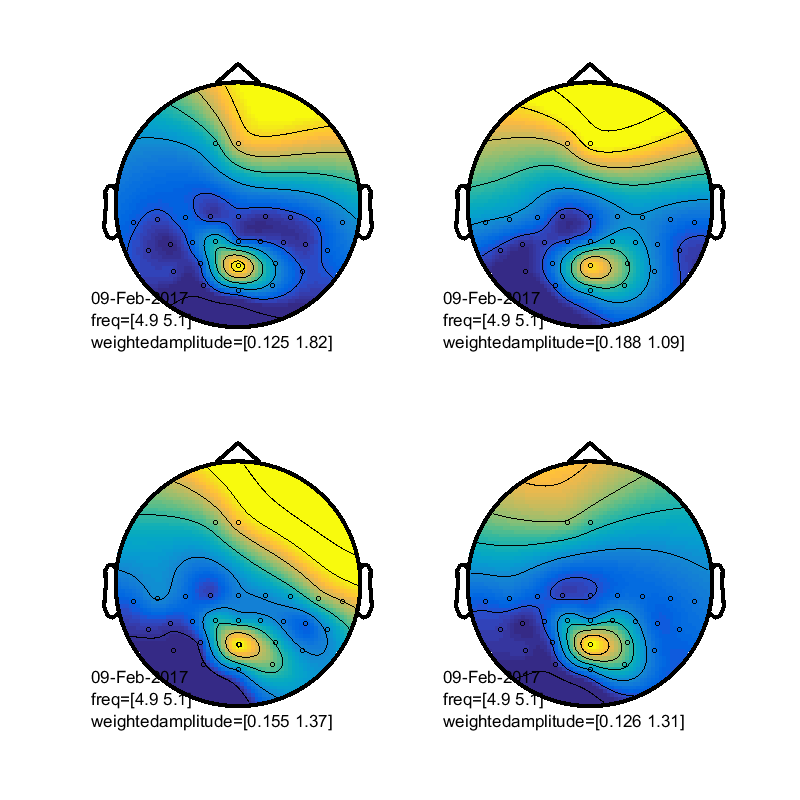

reading layout from file biosemi64.lay
the call to "ft_prepare_layout" took 0 seconds
> In topoplot_common (line 763)
  In ft_topoplotTFR (line 195)
the call to "ft_topoplotTFR" took 0 seconds
reading layout from file biosemi64.lay
the call to "ft_prepare_layout" took 0 seconds
> In topoplot_common (line 763)
  In ft_topoplotTFR (line 195)
the call to "ft_topoplotTFR" took 0 seconds
reading layout from file biosemi64.lay
the call to "ft_prepare_layout" took 0 seconds
> In topoplot_common (line 763)
  In ft_topoplotTFR (line 195)
the call to "ft_topoplotTFR" took 0 seconds
reading layout from file biosemi64.lay
the call to "ft_prepare_layout" took 0 seconds
> In topoplot_common (line 763)
  In ft_topoplotTFR (line 195)
the call to "ft_topoplotTFR" took 0 seconds


In [21]:
%plot -s 800,800

figure;
cfg = [];
cfg.xlim = [4.9, 5.1];
cfg.parameter = 'weightedamplitude';
% cfg.zlim = [0, 5];
cfg.layout = 'biosemi64.lay';

for i = 1:numel(triggers)
    subplot(2, 2, i);
    data = getfield(load(fullfile(filedir, ['saturation_grandav_', num2str(triggers(i)), '.mat'])), 'grandavg');
    
    ft_topoplotTFR(cfg, data);
    colormap parula
end